<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_1/notebooks/demo_python_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples of AD in Python

Here we show examples of AD in comparison to symbolic differentiation in pytorch, tensorflow and jax

In [ ]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import jax

Let's start with the following equation:
# $$f(x) = \sin(2x) + x^2$$

We first try out symbolic differentiation with sympy

In [ ]:
# define symbols
x = sympy.symbols('x')

# define function
def f(x):
    return sympy.sin(2*x) + x**2
f(x)

x**2 + sin(2*x)

In [ ]:
# compute derivative
df = sympy.diff(f(x), x)
df

2*x + 2*cos(2*x)

In [ ]:
# evaluate derivative at x=2
df.subs(x, 2)

2*cos(4) + 4

In [ ]:
# evaluate derivative at x=2
df.subs(x, 2).evalf()

2.69271275827278

Exactly right! :)

What about more complex functions?

In [ ]:
# define sigmoid function
def sigmoid(x):
    return 1 / (1 + sympy.exp(-x))
sympy.diff(sigmoid(x), x)

exp(-x)/(1 + exp(-x))**2

In [ ]:
sympy.diff(sigmoid(sigmoid(x)), x)

exp(-x)*exp(-1/(1 + exp(-x)))/((1 + exp(-x))**2*(1 + exp(-1/(1 + exp(-x))))**2)

In [ ]:
sympy.diff(sigmoid(sigmoid(sigmoid(x))), x)

exp(-x)*exp(-1/(1 + exp(-x)))*exp(-1/(1 + exp(-1/(1 + exp(-x)))))/((1 + exp(-x))**2*(1 + exp(-1/(1 + exp(-x))))**2*(1 + exp(-1/(1 + exp(-1/(1 + exp(-x))))))**2)

Expressions swell! Slow! Inflexible!

Good if we want analytic solutions of well behaved functions. But...

* lacks flexibility!
* slow!
* most of the time there is no need for closed form expressions!

# Frameworks for Differentiable Programming
Building computational graphs and doing AD

Examples: Tensorflow 1 and 2, Pytorch (Autograd), Jax, Flux (Zygote)


All do this:
* take source code of your program
* **build computational graph** for automatic differentiation
* **offload compute-heavy operations** to fast kernels in low level language


All make different tradeoffs in how the computational graph is
* constructed
* represented
* optimized

# What's missing?

Control flow!

Tradeoffs appear in different approaches to shield AD from dynamic control flow.

Choose!
* build a static graph which executes different subgraphs depending on the input
* dynamically generate graph during execution

# Dynamic graph generation for every forward operation
PyTorch example

In [ ]:
x = torch.tensor(2.0, requires_grad=True)

def f_torch(x):
    print("calculating f(x)")
    return torch.sin(2*x) + x**2

y = f_torch(x)
y

calculating f(x)


tensor(3.2432, grad_fn=<AddBackward0>)

In [ ]:
y.backward()

x.grad

tensor(2.6927)

# Static graph generation before evaluation
Tensorflow example

In [ ]:
x = tf.Variable(2.0)

@tf.function
def f_tf(x):
    print("Hello Python!")                  # this will only be printed once
    tf.print("Hello Tensorflow!")
    return tf.sin(2*x) + x**2

with tf.GradientTape(persistent=True) as tape:  # record the gradients
    tape.watch(x)
    y = f_tf(x)

dy = tape.gradient(y, x)
print(dy)

Hello Python!
Hello Tensorflow!
tf.Tensor(2.6927128, shape=(), dtype=float32)


In [ ]:
f_tf(x)     # this will not print "Hello Python!" again

Hello Tensorflow!


<tf.Tensor: shape=(), dtype=float32, numpy=3.2431974>

# Further optimize computation graph with Just-In-Time Compilation

JAX example

In [ ]:
x = 2.0                 # regular Python float
def f_jax(x):
    return jax.numpy.sin(2*x) + x**2

jax.grad(f_jax)(x)

Array(2.6927128, dtype=float32, weak_type=True)

In [ ]:
jax.make_jaxpr(f_jax)(x)

{ lambda ; a:f32[]. let
    b:f32[] = mul 2.0 a
    c:f32[] = sin b
    d:f32[] = integer_pow[y=2] a
    e:f32[] = add c d
  in (e,) }

Source code transformation as opposed to operator overloading

note: Translating the source to an Intermediate Representation (IR) like Jaxpr or XLA (= Accelerated Linear Algebra) allows for optimizations like operator fusion.

Think of this as a domain specific compiling.

Instead of transforming source code to build a comp graph, optimize and JIT compile it, we could use the language compiler.

# Implementing a minimal automatic differentiation

$$f(x) = \sin(2x) + x^2$$

Here is our program witout AD.

In [ ]:
def mul_func(x1,x2):
    return x1*x2

def sum_func(x1,x2):
    return x1+x2

def sin_func(x):
    return np.sin(x)

def function(x):
    two_x = mul_func(2,x)
    sin_two_x = sin_func(two_x)
    square_x = mul_func(x,x)
    return sum_func(sin_two_x,square_x)

print(function(2))

3.2431975046920716


For forward mode AD, we need to implement the Jacobian Vector Product (JVP) for each operation.

In [ ]:
def mul_jvp(x1,dx1,x2,dx2):
    y  = mul_func(x1,x2)
    dy = x1*dx2 + x2*dx1
    return y, dy

def sum_jvp(x1,dx1,x2,dx2):
    return sum_func(x1,x2), dx1 + dx2

def sin_jvp(x,dx):
    return sin_func(x), np.cos(x)*dx

In [ ]:
def function_jvp(x,dx):
    two_x, two_dx = mul_jvp(2,0,x,dx)
    sin_two_x, sin_two_dx = sin_jvp(two_x,two_dx)
    square_x, square_dx = mul_jvp(x,dx,x,dx)
    return sum_jvp(sin_two_x,sin_two_dx,square_x,square_dx)

function_jvp(2,1)

(3.2431975046920716, 2.6927127582727763)

Exactly right, again! And so much faster!

How about reverse mode AD?

For reverse mode AD, we need to **implement Vector Jacobian Products** for each of the operations ...

In [ ]:
def mul_vjp(x1,x2,dx1,dx2,dout):
    dx2 += dout * x1
    dx1 += dout * x2
    return dx1,dx2

def sum_vjp(x1,x2,dx1,dx2,dout):
    dx1 += dout * 1
    dx2 += dout * 1
    return dx1,dx2

def sin_vjp(x,dx,dout):
    dx += dout * np.cos(x)
    return dx

... and **pull back the gradients along the computational graph**.

In [ ]:
def function_vjp(x,dy):

    # run forward
    two_x = mul_func(2,x)
    sin_two_x = sin_func(two_x)
    square_x = mul_func(x,x)
    y = sum_func(sin_two_x,square_x)

    # zero gradients
    d_x = 0
    d_two_x = 0
    d_sin_two_x = 0
    d_square_x = 0

    # run backward
    d_sin_two_x, d_square_x = sum_vjp(sin_two_x,square_x,d_sin_two_x,d_square_x,dy)
    d_two_x = sin_vjp(two_x,d_two_x,d_sin_two_x)
    _, d_x = mul_vjp(2,x,0,d_x,d_two_x)
    d_x,_ = mul_vjp(x,x,d_x,d_x,d_square_x)
    d_x,_ = mul_vjp(x,x,d_x,d_x,d_square_x)

    return y, d_x

function_vjp(2,1)

(3.2431975046920716, 2.6927127582727763)

Text(0.5, 1.0, 'Derivative of $f(x) = \\sin(2x) + x^2$')

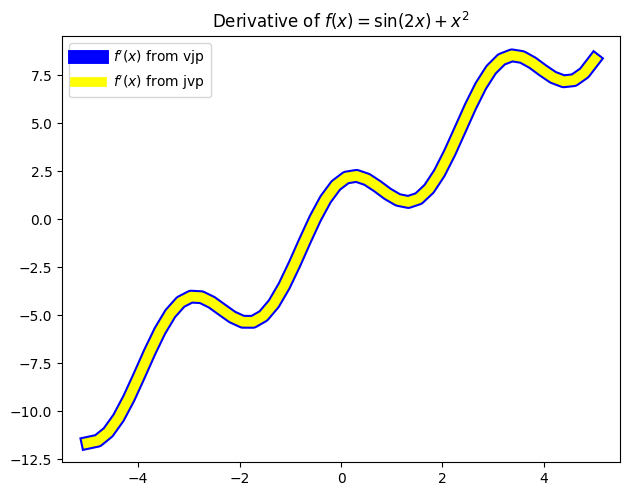

In [ ]:
xs = np.linspace(-5,5)
plt.plot(xs, [function_vjp(x,1)[1] for x in xs], linewidth=10, color="blue", label="$f'(x)$ from vjp")
plt.plot(xs, [function_jvp(x,1)[1] for x in xs], linewidth=7, color="yellow", label="$f'(x)$ from jvp")
#plt.plot(xs, sympy.lambdify(x, df, 'numpy')(xs), linewidth=3, color="red", label="$f'(x)$ from sympy")
plt.legend(); plt.tight_layout(); plt.title("Derivative of $f(x) = \sin(2x) + x^2$")